In [3]:
from fastmri.data.subsample import create_mask_for_mask_type

mask_type = "random" # or equispaced
center_fractions = [0.08, 0.04]
accelerations = [4, 8]
mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)
from modules.kspace_data import KspaceSample

s = KspaceSample(0,1)
s[0]

0

In [1]:
from pl_modules import PixelCNNModule, ReconstructKspaceDataModule
import pytorch_lightning as pl
from pathlib import Path
from modules.kspace_data import KspaceDataTransform

model = PixelCNNModule()
dm = ReconstructKspaceDataModule(
    Path("knee_dataset"),
    challenge="singlecoil",
    train_transform=KspaceDataTransform(),
    val_transform=KspaceDataTransform(),
    test_transform=KspaceDataTransform(),
    batch_size=1,
    num_workers=4)
trainer = pl.Trainer(max_epochs=2, default_root_dir="./pixelcnn/")

c:\Users\sandr\source\repos\pixelcnn_experiment\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dm)


  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | PixelCNN | 1.4 M  | train
-------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.637     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:03<00:03,  0.28it/s]

c:\Users\sandr\source\repos\pixelcnn_experiment\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0:   0%|          | 2/7135 [00:27<27:24:55,  0.07it/s, v_num=9]      


Detected KeyboardInterrupt, attempting graceful shutdown ...


In [3]:
from modules.model import PixelCNN, rearrange_kspace, laplace_nll
from torch import optim
model = PixelCNN()

dl = dm.train_dataloader()
optimizer = optim.Adam(model.parameters())
model.train(True)
for i,batch in enumerate(dl):
    print(i)
    input = rearrange_kspace(batch.masked_kspace,0)
    target = rearrange_kspace(batch.kspace,0)
    mean, log = model(input)
    loss = laplace_nll(mean,log,target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i > 50:
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


# Agenda to discuss
- different kspace shapes (for forward diffusion equal shape is required)
- output values (images: 256, because in paper they use softmax for probabilities)
- split real and imaginary channel?
- full kspace to full kspace, noisy kspace to full kspace, undersampled kspace to full kspace 
- different masking, 1D convolutions, multiplications instead of convolutions

In [86]:
import numpy as np
samples = None
for i, sample in enumerate(dataloader):
    point = sample.masked_kspace[:,:,:,0].numpy().ravel()
    if i>0:
        samples = np.append(samples, point)
    else:
        samples = point
    if i >= 300:
        print(i)
        break
print(samples.shape)

300
(71293440,)


In [2]:
import os
print(os.listdir("knee_singlecoil")):

['singlecoil_test', 'singlecoil_val']


In [87]:
print(len(set(samples.tolist())))

10873542


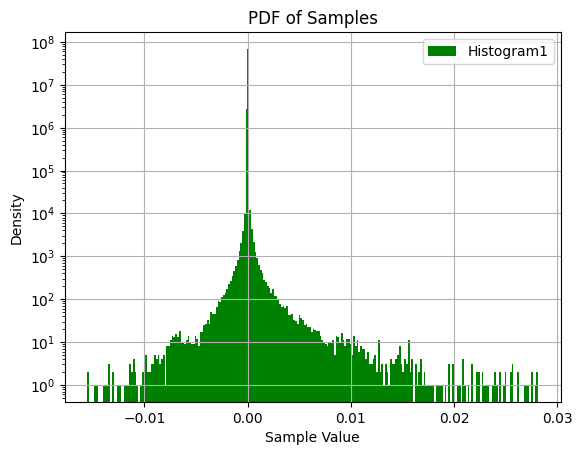

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Step 1: Generate or load samples (example: normal distribution)
# samples = np.random.normal(loc=0, scale=1, size=(1000,))  # 1000 samples from N(0, 1)
# print(samples.shape)

# Step 2a: Estimate PDF using a histogram
# plt.hist([samples[:235520], samples[235520:2*235520]], bins=256, density=False, color=['g','b'], label=['Histogram1', 'Histogram2'], log=True, stacked=True)
plt.hist(samples, bins=256, density=False, color='g', label='Histogram1', log=True)

# Step 2b: Estimate PDF using Kernel Density Estimation (KDE)
# kde = gaussian_kde(samples)
# x = np.linspace(min(samples), max(samples), samples.shape[0])  # Create a range for x values# pdf = kde(x)  # Evaluate the KDE at these points
# plt.plot(x, pdf, color='blue', label='KDE')

# Step 3: Customize and display the plot
plt.title('PDF of Samples')
plt.xlabel('Sample Value')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()


In [70]:
import h5py
import os
from fastmri.data import transforms as T
mi = 0
ma = 0
path = "knee_singlecoil_val/singlecoil_val"
for file in os.listdir(path):
    hf = h5py.File(os.path.join(path,file))
    kspace =T.to_tensor(hf["kspace"][()])
    if kspace.min() < mi:
        mi = kspace.min()
    if kspace.max() > ma:
        ma = kspace.max()
print("Max: ", ma)
print("Min: ", mi)

Max:  tensor(0.0618)
Min:  tensor(-0.0298)


In [4]:
# just for degbuggin purpose:
mins = set()
maxs = set()
shapes = set()
for batch in dataloader:
    shapes.add(batch.masked_kspace.shape)
    mins.add(batch.masked_kspace.min())
    maxs.add(batch.masked_kspace.max())

print(min(mins))
print(max(maxs))

tensor(-0.0298)
tensor(0.0618)


In [5]:
shapes

{torch.Size([1, 640, 320, 2]),
 torch.Size([1, 640, 338, 2]),
 torch.Size([1, 640, 356, 2]),
 torch.Size([1, 640, 368, 2]),
 torch.Size([1, 640, 372, 2]),
 torch.Size([1, 640, 386, 2]),
 torch.Size([1, 640, 400, 2]),
 torch.Size([1, 640, 454, 2]),
 torch.Size([1, 640, 644, 2])}

In [3]:
from modules.model import PixelCNN
from torch import optim
from torch.nn import CrossEntropyLoss
model = PixelCNN(in_channels=1)
optimizer = optim.Adam(model.parameters())

In [20]:
class Trainer():
    def __init__(self, model, dataloader, n_epochs, criterion, optimizer):
        self.model = model
        self.dataloader = dataloader
        self.n_epochs = n_epochs
        self.criterion = criterion
        self.optimizer = optimizer(self.model.parameters())
    
    def train(self):
        model.train(True)
        for epoch in tqdm(range(self.n_epochs), desc="Epochs"):
            epoch_loss = 0.0
            with tqdm(self.dataloader, desc=f"Epoch {epoch+1}", unit="batch") as tepoch:
                for batch in tepoch:
                    input = batch.masked_kspace.permute(0,3,1,2)[:,0,:].unsqueeze(1)
                    target = batch.target.permute(0,3,1,2)[:,0,:].long()
                    output = self.model(input)
                    loss = self.criterion(output, target)
                    self.optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    tepoch.set_postfix(loss=loss.item())
                    epoch_loss += loss.item()
            print(f"Epoch {epoch+1}/{self.n_epochs}, Loss: {epoch_loss:.4f}")

In [22]:
trainer = Trainer(PixelCNN(), dataloader, 5, CrossEntropyLoss(), optim.Adam)

In [23]:
trainer.train()

Epochs:   0%|          | 0/5 [1:43:53<?, ?it/s]


KeyboardInterrupt: 

In [5]:
loss_train = []
for epoch in tqdm(range(5), desc="Epochs"):
    model.train(True)
for batch in tqdm(dataloader, desc="Training"):
    input = batch.masked_kspace.permute(0,3,1,2)[:,0,:].unsqueeze(1)
    # print("Input shape: ",input.shape)
    target = batch.target.permute(0,3,1,2)[:,0,:].long()
    # print("Target shape: ", target.shape)
    # print("Output shape: ", model(input).shape)
    # target = Variable((input.data[:,0] * 255).long())
    loss = F.cross_entropy(model(input), target)
    loss_train.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Training:   0%|          | 0/7135 [00:03<?, ?it/s]


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [25]:
import os
import time
import sys

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim, cuda, backends
from torch.autograd import Variable
from torch.utils import data
from torchvision import datasets, transforms, utils
backends.cudnn.benchmark = True


class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

fm = 64
net = nn.Sequential(
    MaskedConv2d('A', 1,  fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    MaskedConv2d('B', fm, fm, 7, 1, 3, bias=False), nn.BatchNorm2d(fm), nn.ReLU(True),
    nn.Conv2d(fm, 256, 1))

tr = data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
                     batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
te = data.DataLoader(datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor()),
                     batch_size=128, shuffle=False, num_workers=1, pin_memory=True)

class TrainerMNIST():
    def __init__(self, model, dataloader, n_epochs, criterion, optimizer):
        self.model = model
        self.dataloader = dataloader
        self.n_epochs = n_epochs
        self.criterion = criterion
        self.optimizer = optimizer(self.model.parameters())
    
    def train(self):
        model.train(True)
        for epoch in tqdm(range(self.n_epochs), desc="Epochs"):
            epoch_loss = 0.0
            with tqdm(self.dataloader, desc=f"Epoch {epoch+1}", unit="batch") as tepoch:
                for input,_ in tepoch:
                    input = Variable(input)
                    target = Variable((input.data[:,0] * 255).long())
                    output = self.model(input)
                    loss = self.criterion(output, target)
                    self.optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    tepoch.set_postfix(loss=loss.item())
                    epoch_loss += loss.item()
                    print(f"Epoch {epoch+1}/{self.n_epochs}, Loss: {epoch_loss:.4f}")

mnist_trainer = TrainerMNIST(net, tr, 5, CrossEntropyLoss(), optim.Adam)
mnist_trainer.train()

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5, Loss: 5.6579


Epoch 1/5, Loss: 11.3201


Epoch 1/5, Loss: 16.9762


Epoch 1/5, Loss: 22.6377


Epoch 1/5, Loss: 28.2965


Epoch 1/5, Loss: 33.9540


Epoch 1/5, Loss: 39.6133


Epoch 1/5, Loss: 45.2711


Epoch 1/5, Loss: 50.9296


Epoch 1/5, Loss: 56.5891


Epoch 1/5, Loss: 62.2424


Epoch 1/5, Loss: 67.8991


Epoch 1/5, Loss: 73.5585


Epoch 1/5, Loss: 79.2170


Epoch 1/5, Loss: 84.8719


Epoch 1/5, Loss: 90.5316


Epoch 1/5, Loss: 96.1931


Epoch 1/5, Loss: 101.8493


Epoch 1/5, Loss: 107.5085


Epoch 1/5, Loss: 113.1685


Epoch 1/5, Loss: 118.8277


Epochs:   0%|          | 0/5 [01:39<?, ?it/s]


KeyboardInterrupt: 

In [5]:
import torch
import torch.nn as nn

# Input tensor of shape (1, 2, 640, 320)
input_tensor = torch.randn(1, 2, 640, 320)

# Define the grouped 2D convolution
conv = nn.Conv2d(
    in_channels=2,   # Input channels
    out_channels=256 * 2,  # Output channels (256 for each input channel)
    kernel_size=1,    # Kernel size 1x1 (no change to spatial dimensions)
    groups=2          # Groups = in_channels (for separate convolutions per channel)
)

# Apply the convolution
output = conv(input_tensor)

print(output.shape)
# Reshape the output to the desired shape (1, 2, 256, 640, 320)
output = output.view(1, 2, 256, 640, 320)

# Print the final shape
print(output.shape)  # torch.Size([1, 2, 256, 640, 320])


torch.Size([1, 512, 640, 320])
torch.Size([1, 2, 256, 640, 320])


In [6]:
import torch

# Example tensor with shape [1, 640, 320, 2]
tensor = torch.randn(1, 640, 320, 2)

# Rearrange dimensions to [1, 2, 640, 320]
tensor_reshaped = tensor.permute(0, -1, 1, 2)
tensor_reshaped.shape

torch.Size([1, 2, 640, 320])

In [7]:
import numpy as np

# Example values ranging from -0.0298 to 0.0618
values = np.array([-0.0298, 0.0, 0.03, 0.0618])  # Replace with your actual data

# Min and Max of the original range
min_val = -0.0298
max_val = 0.0618

# Normalization to range [0, 1]
normalized_values = (values - min_val) / (max_val - min_val)

print("Original values:", values)
print("Normalized values:", normalized_values)


Original values: [-0.0298  0.      0.03    0.0618]
Normalized values: [0.         0.32532751 0.65283843 1.        ]


In [ ]:
from torchsummary import summary
summary(gated_model, (1,28,28))

NameError: name 'gated_model' is not defined

In [1]:
from torch.utils import data
from torchvision import datasets, transforms, utils
tr = data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
                     batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils import data
from torchvision import datasets, transforms, utils
from torch.distributions import Laplace
import numpy as np
import time
from modules.model import PixelCNN, laplace_nll

net = PixelCNN()

# Data Loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0,), std=(1.0,))  # Assume Laplace distributed inputs are mean 0, std 1
])

train_loader = data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transform),
                                batch_size=128, shuffle=True)
test_loader = data.DataLoader(datasets.MNIST('data', train=False, transform=transform),
                               batch_size=128, shuffle=False)

# Training Setup
sample = torch.zeros(144, 1, 28, 28)
optimizer = optim.Adam(net.parameters())

# Training Loop
for epoch in range(25):
    # Training Phase
    net.train()
    train_loss = []
    time_tr = time.time()
    for input, _ in train_loader:
        input = input
        print(input.shape)
        target = input

        mean, log_scale = net(input)  # Predict mean and log_scale
        print("Mean: ", mean.shape)
        print("Log: ", log_scale.shape)
        loss = laplace_nll(mean, log_scale, target)  # Laplace NLL loss
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    time_tr = time.time() - time_tr

    # Testing Phase
    net.eval()
    test_loss = []
    time_te = time.time()
    with torch.no_grad():
        for input, _ in test_loader:
            input = input.cuda()
            target = input

            mean, log_scale = net(input)  # Predict mean and log_scale
            loss = laplace_nll(mean, log_scale, target)  # Laplace NLL loss
            test_loss.append(loss.item())
    time_te = time.time() - time_te

    # Sampling
    sample.fill_(0)
    net.eval()
    with torch.no_grad():
        for i in range(28):
            for j in range(28):
                mean, log_scale = net(sample)
                scale = torch.exp(log_scale[:, :, i, j])  # Convert log_scale to scale
                dist = Laplace(mean[:, :, i, j], scale)
                sample[:, :, i, j] = dist.sample().clamp(0, 1)  # Sample and clamp values to [0, 1]

    utils.save_image(sample, 'sample_{:02d}.png'.format(epoch), nrow=12, padding=0)

    print(f'Epoch {epoch}: Train Loss={np.mean(train_loss):.7f}, '
          f'Test Loss={np.mean(test_loss):.7f}, '
          f'Train Time={time_tr:.2f}s, Test Time={time_te:.2f}s')

torch.Size([128, 1, 28, 28])
Mean:  torch.Size([128, 1, 28, 28])
Log:  torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Mean:  torch.Size([128, 1, 28, 28])
Log:  torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Mean:  torch.Size([128, 1, 28, 28])
Log:  torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Mean:  torch.Size([128, 1, 28, 28])
Log:  torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Mean:  torch.Size([128, 1, 28, 28])
Log:  torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Mean:  torch.Size([128, 1, 28, 28])
Log:  torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Mean:  torch.Size([128, 1, 28, 28])
Log:  torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Mean:  torch.Size([128, 1, 28, 28])
Log:  torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Mean:  torch.Size([128, 1, 28, 28])
Log:  torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
Mean:  torch.Size([128, 1, 28, 28])
Log:  torch.Size([128, 1, 28, 28])


KeyboardInterrupt: 